In [10]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import random as rand
%matplotlib inline
import matplotlib.pyplot as plt 


transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])



trainset = datasets.SVHN('data', split="train", download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.SVHN('data', split="test", download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=6128, shuffle=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [12]:
image, label = next(iter(trainloader))
print(len(trainset))
print(len(testset))



73257
26032


In [13]:
image.shape
(image.view(image.shape[0],-1)).shape


torch.Size([128, 3072])

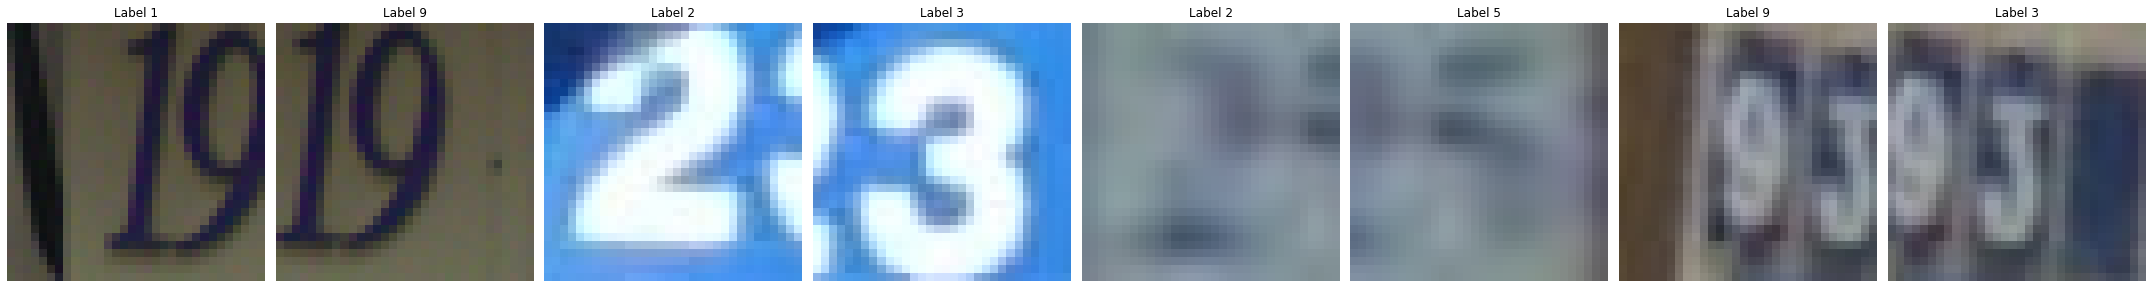

In [14]:
fig, ax = plt.subplots(1, 8)
fig.set_size_inches(30, 4)
for i in range(8):
    img, lbl = trainset[i]
    img_disp = img.permute(1,2,0)
    ax[i].imshow(img_disp)
    ax[i].axis("off")
    ax[i].set_title(f"Label {lbl}")

plt.tight_layout()
plt.show()

In [17]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms



class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x


In [18]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
steps = 0


train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 2.175..  Test Loss: 2.045..  Test Accuracy: 0.260
Epoch: 2/30..  Training Loss: 1.718..  Test Loss: 1.603..  Test Accuracy: 0.448
Epoch: 3/30..  Training Loss: 1.495..  Test Loss: 1.525..  Test Accuracy: 0.497
Epoch: 4/30..  Training Loss: 1.356..  Test Loss: 1.424..  Test Accuracy: 0.556
Epoch: 5/30..  Training Loss: 1.253..  Test Loss: 1.318..  Test Accuracy: 0.587
Epoch: 6/30..  Training Loss: 1.200..  Test Loss: 1.297..  Test Accuracy: 0.595
Epoch: 7/30..  Training Loss: 1.155..  Test Loss: 1.263..  Test Accuracy: 0.608
Epoch: 8/30..  Training Loss: 1.121..  Test Loss: 1.258..  Test Accuracy: 0.614
Epoch: 9/30..  Training Loss: 1.097..  Test Loss: 1.204..  Test Accuracy: 0.628
Epoch: 10/30..  Training Loss: 1.056..  Test Loss: 1.160..  Test Accuracy: 0.651
Epoch: 11/30..  Training Loss: 1.014..  Test Loss: 1.270..  Test Accuracy: 0.620
Epoch: 12/30..  Training Loss: 0.987..  Test Loss: 1.096..  Test Accuracy: 0.675
Epoch: 13/30..  Training Loss: 0.948.

In [19]:
import numpy as np
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 32, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "SVNH":
        ax2.set_yticklabels(np.arange(10))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

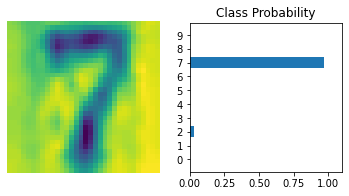

In [32]:
# Import helper module (should be in the repo)


# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 3072)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)
view_classify(img.view(3, 32, 32), ps, version='SVNH')
